<a href="https://colab.research.google.com/github/SerafinCarba/Ejercicio-de-introducci-n-a-las-redes-neuronales/blob/master/intro_to_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Introducción a las redes neuronales

 **Objetivos de aprendizaje:**
  * definir una red neuronal (RN) y sus capas ocultas a través de la clase `DNNRegressor` de TensorFlow
  * entrenar una red neuronal para aprender no linealidades en un conjunto de datos y lograr un mejor rendimiento que un modelo de regresión lineal

 En los ejercicios anteriores, usamos atributos sintéticos para ayudar a nuestro modelo a incorporar no linealidades.

Había un conjunto de no linealidades importante en torno a latitud y longitud, pero pueden existir otros.

Por el momento también volveremos a una tarea de regresión estándar, en lugar de la tarea de regresión logística del ejercicio anterior. Esto significa que prediremos `median_house_value` directamente.

 ## Preparación

Primero, carguemos y preparemos los datos.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [31]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2630.9,536.3,1424.6,498.4,3.9,2.0
std,2.1,2.0,12.6,2143.7,413.5,1142.2,378.0,1.9,1.2
min,32.5,-124.3,1.0,11.0,3.0,3.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1460.0,296.0,788.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2130.5,434.0,1169.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3140.2,648.0,1720.0,603.2,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2674.3,546.9,1441.6,507.9,3.9,2.0
std,2.2,2.0,12.6,2264.6,439.9,1161.4,399.7,1.9,1.1
min,32.5,-124.3,2.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.7,18.0,1465.8,299.0,792.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2120.5,434.0,1162.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3172.2,650.0,1724.5,607.2,4.8,2.3
max,42.0,-114.6,52.0,30405.0,4957.0,15037.0,4616.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,207.1
std,115.9
min,15.0
25%,119.2
50%,180.1
75%,265.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.9
std,116.1
min,15.0
25%,120.0
50%,180.6
75%,265.1
max,500.0


 ## Creación de una red neuronal

La RN se define a través de la clase [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor).

Usa **`hidden_units`** para definir la estructura de la RN. El argumento `hidden_units` proporciona una lista de enteros, en la que cada entero corresponde a una capa oculta e indica el número de nodos en ella. Por ejemplo, considera la siguiente asignación:

`hidden_units=[3,10]`

La asignación anterior especifica una red neuronal con dos capas ocultas:

* La primera capa oculta contiene 3 nodos.
* La segunda capa oculta contiene 10 nodos.

Si quisiéramos agregar más capas, incorporaríamos más enteros a la lista. Por ejemplo, `hidden_units=[10,20,30,40]` crearía cuatro capas con diez, veinte, treinta y cuarenta unidades, respectivamente.

De forma predeterminada, todas las capas ocultas usarán activación ReLu y estarán totalmente conectadas.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

 ## Tarea 1: Entrenar un modelo de RN
**Ajusta los hiperparámetros con la intención de disminuir el RMSE por debajo de 110.**

Ejecuta el siguiente bloque para entrenar un modelo de RN.  

Recuerda que, en el ejercicio de regresión lineal, con muchos atributos, un RMSE de aproximadamente 110 era bastante bueno. Intentaremos mejorarlo.
Tu tarea aquí es modificar las distintas configuraciones de aprendizaje para mejorar la exactitud en los datos de validación.

El sobreajuste es un verdadero riesgo potencial para las RN. Puedes observar la brecha entre la pérdida en los datos de entrenamiento y la pérdida en los datos de validación para determinar si tu modelo está comenzando a tener un sobreajuste. Si la brecha comienza a crecer, por lo general es un indicador seguro de sobreajuste.

Debido al número de las diferentes configuraciones posibles, se recomienda enfáticamente tomar nota de cada prueba como guía para el proceso de desarrollo.

Además, cuando obtengas una buena configuración, prueba ejecutarla varias veces y observa qué tan constante es el resultado. Las ponderaciones de RN suelen inicializarse con valores aleatorios pequeños, de manera que debes observar las diferencias entre una ejecución y otra.



Training model...
RMSE (on training data):
  period 00 : 151.03
  period 01 : 144.03
  period 02 : 140.44
  period 03 : 130.78
  period 04 : 123.84
  period 05 : 120.81
  period 06 : 111.19
  period 07 : 107.93
  period 08 : 105.38
  period 09 : 102.83
Model training finished.
Final RMSE (on training data):   102.83
Final RMSE (on validation data): 105.10


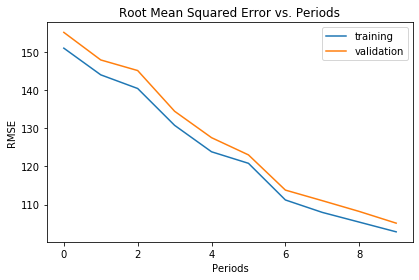

In [35]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solución

Haz clic más abajo para ver una solución posible.

 **NOTA:** Esta selección de parámetros es algo arbitraria. Aquí probamos combinaciones que son cada vez más complejas, combinadas con el entrenamiento durante más tiempo, hasta que el error se encuentra por debajo de nuestro objetivo. Esta no es de ningún modo la mejor combinación; otras pueden alcanzar un RMSE incluso más bajo. Si intentas encontrar el modelo que pueda alcanzar el mejor error, deberás usar un proceso más riguroso, como una búsqueda de parámetros.

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Tarea 2: Evaluar los datos de prueba

**Confirma que los resultados de tu rendimiento de validación respalden los datos de prueba.**

Una vez que tengas un modelo con el que estés satisfecho, evalúalo con los datos de prueba para compararlos con el rendimiento de validación.

Recuerda que el conjunto de datos de prueba está ubicado [aquí](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

In [36]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)


Final RMSE (on test data): 103.42


 ### Solución

Haz clic más abajo para ver una solución posible.

 De manera similar a lo que hace el código de la parte superior, tenemos que cargar el archivo de datos adecuado, procesarlo previamente y llamar a predict y mean_squared_error.

Ten en cuenta que no necesitamos aleatorizar los datos de prueba, dado que usaremos todos los registros.

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)